You will analyze the State of the Union speeches corpus, and report on how the subjects have shifted over time in relation to historical events.

1. Download the source data file ../AssignmentMaterials/state-of-the-union.csv. This is a standard CSV file with one speech per row. There are two columns: the year of the speech, and the text of the speech. You may need to add the line

csv.field_size_limit(1000000000)
to the top of your program to be able to read this large file.

The file is a csv with columns year, text. Note: there are some years where there was more than one speech! Design your data structures accordingly.

2) Feed the data into gensim (https://radimrehurek.com/gensim/ (Links to an external site.)Links to an external site.). Remove special characters, punctuation, stop words etc before modeling.

3) Do LDA topic modeling on a docbow model. You will have to supply the number of topics to generate. Figuring out a good number is part of the assignment. Now, sample the top twenty topics from your set for closer analysis. Print out the 20 topics, each topic as a list of the top 10 words. Try to annotate each of these ten topics with a short descriptive name or phrase that captures what it is “about.” You will likely have to refer to the original documents that contain high proportions of that topic, and you will likely find that some topics have no clear concept.

Turn in: An  ipynb file, a tsv file with the top 10 words of the 20 topics and a description of what these topics contain.

4) Come up with a method to figure out how topics of speeches have changed over time. The goal is to summarize changes in the State of the Union speech in each decade of the 20th and 21st century. There are many different ways to use topic modeling to do this. Possibilities include: visualizations, grouping speeches by decade after topic modeling, or splitting the corpus for each decade before topic modeling.

Turn in: an ipynb file, a description of your decade summarization algorithm, and an analysis of how the topics of the State of the Union have changed over the decades of the 20th century. What patterns do you see? Can you connect the terms to major historical events? (wars, the great depression, assassinations, the civil rights movement, Watergate…)

In [1]:
import logging
import numpy as np
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import gensim
from gensim import models, corpora, similarities
from gensim.utils import smart_open, simple_preprocess
from gensim.corpora.dictionary import Dictionary as Dictionary
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import LdaModel
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wingo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wingo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


# 1

In [2]:
df = pd.read_csv('state-of-the-union.csv', names = ['year', 'text'] )

In [3]:
df.isnull().sum()

year    0
text    0
dtype: int64

In [4]:
df.head(3)

,year,text
0,1790,"George Washington\nJanuary 8, 1790\n\nFellow-C..."
1,1790,\nState of the Union Address\nGeorge Washingto...
2,1791,\nState of the Union Address\nGeorge Washingto...


In [5]:
df.year.nunique()

218

In [6]:
df.year.describe()

count     226.000000
mean     1901.318584
std        65.029944
min      1790.000000
25%      1845.250000
50%      1901.500000
75%      1957.750000
max      2012.000000
Name: year, dtype: float64

# 2

In [7]:
def prep_data(text):
    #get english stopwords
    stop_words = stopwords.words('english')
    #remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #make everything lowercase
    text = text.lower()
    #split to words
    text = nltk.word_tokenize(text)
    #remove stop words
    text = [w for w in text if not w in stop_words]
    return text
df['tokenized_words'] = df.text.apply(prep_data)

In [8]:
df['tokenized_words'].head(3)

0    [george, washington, january, 8, 1790, fellowc...
1    [state, union, address, george, washington, de...
2    [state, union, address, george, washington, oc...
Name: tokenized_words, dtype: object

In [9]:
df['doc_length'] = df['tokenized_words'].apply(lambda x: len(x))


In [10]:
df.doc_length.describe()

count      226.000000
mean      3828.734513
std       2772.249105
min        506.000000
25%       1969.500000
50%       3093.000000
75%       4656.500000
max      19447.000000
Name: doc_length, dtype: float64

Text(0.5, 1.0, 'Distribution of Number of Words per State of the Union')

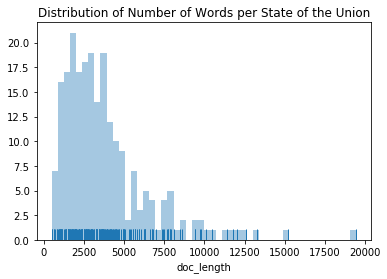

In [11]:
sns.distplot(df.doc_length, bins=50, kde=False, rug=True)
plt.title("Distribution of Number of Words per State of the Union")

[[]]

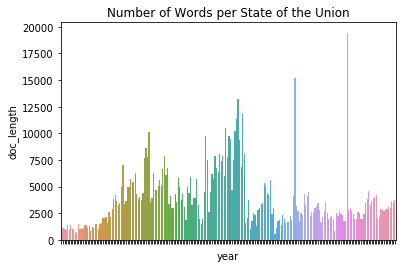

In [12]:
p = sns.barplot(x = df.year, y = df.doc_length, ci=None)
plt.xticks(rotation= 45)
plt.title("Number of Words per State of the Union")
p.set(xticklabels=[])

In [13]:
#take all of the tokenized words get words and count of words
tokenized_words = Counter(np.concatenate(df.tokenized_words.values))
#create a new dataframe
tokenized_words_df = pd.DataFrame.from_dict(tokenized_words, orient='index')

In [14]:
tokenized_words_df.head(3)

,0
george,59
washington,375
january,345


In [15]:
tokenized_words_df.rename(columns={0:'freq'}, inplace =True)
tokenized_words_df = tokenized_words_df.sort_values('freq', ascending = False)


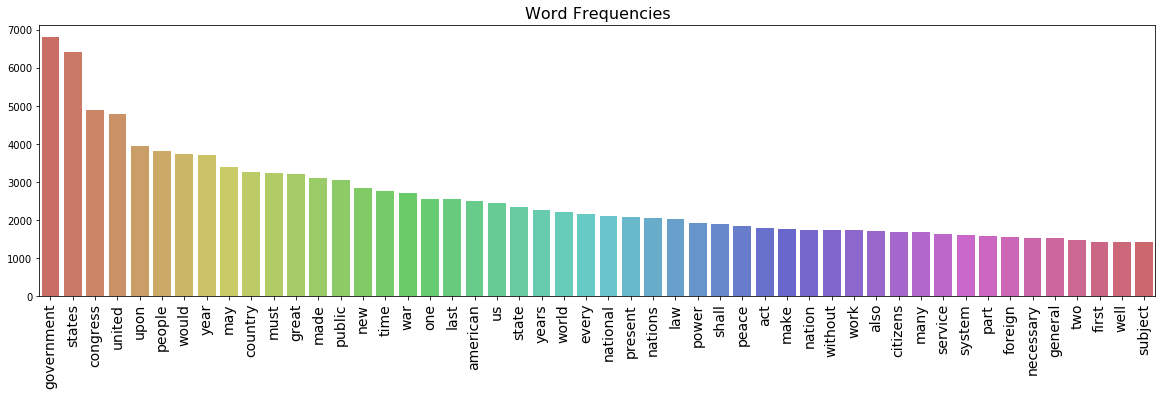

In [16]:
#create a function to look at the top 50 words used
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['freq'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_words_df)
ax.set_title("Word Frequencies", fontsize=16);

In [17]:
tokenized_words_df.shape

(31690, 1)

In [18]:
dictionary =corpora.Dictionary(df['tokenized_words'])
corpus = [dictionary.doc2bow(doc) for doc in df['tokenized_words']]

In [19]:
df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.tokenized_words))

In [20]:
df.head()

,year,text,tokenized_words,doc_length,bow
0,1790,"George Washington\nJanuary 8, 1790\n\nFellow-C...","[george, washington, january, 8, 1790, fellowc...",506,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
1,1790,\nState of the Union Address\nGeorge Washingto...,"[state, union, address, george, washington, de...",639,"[(0, 1), (1, 1), (2, 1), (5, 2), (7, 1), (11, ..."
2,1791,\nState of the Union Address\nGeorge Washingto...,"[state, union, address, george, washington, oc...",1080,"[(6, 2), (7, 1), (9, 1), (10, 1), (11, 1), (12..."
3,1792,\nState of the Union Address\nGeorge Washingto...,"[state, union, address, george, washington, no...",977,"[(2, 2), (4, 2), (5, 3), (6, 1), (11, 1), (12,..."
4,1793,\nState of the Union Address\nGeorge Washingto...,"[state, union, address, george, washington, de...",911,"[(4, 1), (11, 1), (12, 1), (19, 1), (20, 1), (..."


# 3

In [21]:
dictionary =corpora.Dictionary(df['tokenized_words'])
corpus = [dictionary.doc2bow(doc) for doc in df['tokenized_words']]
#make an lda model to look at the top 20 topics
lda = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary,
               alpha=1e-2, eta=0.5e-2,
               chunksize=2000, minimum_probability=0.0, passes=15)

In [22]:
topics = lda.show_topics(num_words=10, log=False, formatted=True)
topics

[(9,
  '0.007*"made" + 0.007*"government" + 0.006*"ought" + 0.006*"would" + 0.006*"one" + 0.005*"may" + 0.005*"congress" + 0.005*"country" + 0.005*"must" + 0.005*"public"'),
 (5,
  '0.010*"people" + 0.010*"must" + 0.008*"us" + 0.008*"america" + 0.008*"new" + 0.007*"years" + 0.007*"american" + 0.006*"year" + 0.006*"world" + 0.006*"americans"'),
 (0,
  '0.007*"government" + 0.006*"must" + 0.006*"national" + 0.005*"great" + 0.005*"public" + 0.005*"business" + 0.005*"law" + 0.005*"congress" + 0.005*"people" + 0.004*"work"'),
 (1,
  '0.001*"states" + 0.001*"united" + 0.001*"upon" + 0.001*"government" + 0.001*"congress" + 0.001*"would" + 0.001*"country" + 0.001*"made" + 0.001*"people" + 0.001*"public"'),
 (4,
  '0.011*"world" + 0.011*"war" + 0.009*"must" + 0.008*"nations" + 0.006*"year" + 0.006*"united" + 0.006*"peace" + 0.006*"free" + 0.005*"economic" + 0.005*"program"'),
 (16,
  '0.002*"states" + 0.002*"united" + 0.002*"government" + 0.002*"upon" + 0.002*"congress" + 0.002*"people" + 0.002

In [23]:
#print out the topic# and 10 words having to deal with each topic
for index, topic in lda.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(index, topic))

Topic: 0 
Words: 0.007*"government" + 0.006*"must" + 0.006*"national" + 0.005*"great" + 0.005*"public" + 0.005*"business" + 0.005*"law" + 0.005*"congress" + 0.005*"people" + 0.004*"work"
Topic: 1 
Words: 0.001*"states" + 0.001*"united" + 0.001*"upon" + 0.001*"government" + 0.001*"congress" + 0.001*"would" + 0.001*"country" + 0.001*"made" + 0.001*"people" + 0.001*"public"
Topic: 2 
Words: 0.008*"new" + 0.006*"congress" + 0.005*"us" + 0.005*"must" + 0.005*"federal" + 0.005*"government" + 0.004*"years" + 0.004*"nations" + 0.004*"world" + 0.004*"year"
Topic: 3 
Words: 0.010*"government" + 0.008*"states" + 0.007*"upon" + 0.006*"would" + 0.006*"united" + 0.005*"congress" + 0.005*"people" + 0.004*"may" + 0.004*"made" + 0.004*"great"
Topic: 4 
Words: 0.011*"world" + 0.011*"war" + 0.009*"must" + 0.008*"nations" + 0.006*"year" + 0.006*"united" + 0.006*"peace" + 0.006*"free" + 0.005*"economic" + 0.005*"program"
Topic: 5 
Words: 0.010*"people" + 0.010*"must" + 0.008*"us" + 0.008*"america" + 0.008*

In [24]:
topicsdf = pd.DataFrame(data ={'topics':topics})
topicsdf[['topic_number', 'topic']] = pd.DataFrame(topicsdf['topics'].tolist())
topicsdf = topicsdf.drop(['topics'],axis=1)


In [25]:
topicwords = []
for t in range(lda.num_topics):
    topicwords.extend([(t, ) + x for x in lda.show_topic(t, topn = 10)])

df_to_save = pd.DataFrame(topicwords, columns=['Topic_num', 'Word', 'Probablity'])
df_to_save.to_csv("topicword.tsv",sep = "\t" )
df_to_save

,Topic_num,Word,Probablity
0,0,government,0.007471
1,0,must,0.006020
2,0,national,0.005600
3,0,great,0.005103
4,0,public,0.005007
5,0,business,0.004695
6,0,law,0.004672
7,0,congress,0.004619
8,0,people,0.004592
9,0,work,0.004475


# 4

In [26]:
df.head(3)

,year,text,tokenized_words,doc_length,bow
0,1790,"George Washington\nJanuary 8, 1790\n\nFellow-C...","[george, washington, january, 8, 1790, fellowc...",506,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
1,1790,\nState of the Union Address\nGeorge Washingto...,"[state, union, address, george, washington, de...",639,"[(0, 1), (1, 1), (2, 1), (5, 2), (7, 1), (11, ..."
2,1791,\nState of the Union Address\nGeorge Washingto...,"[state, union, address, george, washington, oc...",1080,"[(6, 2), (7, 1), (9, 1), (10, 1), (11, 1), (12..."


In [27]:
twentieth_cent = df[(df.year > 1990)&(df.year<2001)]
twentieth_first = df[df.year>2000]

In [28]:
twentieth_cent.head(3)

,year,text,tokenized_words,doc_length,bow
203,1991,\nState of the Union Address\nGeorge H.W. Bush...,"[state, union, address, george, hw, bush, janu...",1971,"[(2, 1), (7, 1), (17, 1), (20, 5), (21, 3), (2..."
204,1992,\nState of the Union Address\nGeorge H.W. Bush...,"[state, union, address, george, hw, bush, janu...",2402,"[(5, 1), (12, 3), (17, 1), (20, 1), (21, 1), (..."
205,1993,\nAddress on Administration Goals\nWilliam J. ...,"[address, administration, goals, william, j, c...",3447,"[(7, 2), (12, 1), (15, 2), (19, 2), (20, 10), ..."


In [29]:
twentieth_first.head(3)

,year,text,tokenized_words,doc_length,bow
213,2001,\nAddress on Administration Goals (Budget Mess...,"[address, administration, goals, budget, messa...",2370,"[(1, 1), (5, 3), (7, 2), (15, 3), (19, 1), (20..."
214,2001,\nState of the Union Address\nGeorge W. Bush\n...,"[state, union, address, george, w, bush, septe...",1510,"[(7, 1), (18, 1), (19, 4), (20, 2), (21, 1), (..."
215,2002,\nState of the Union Address\nGeorge W. Bush\n...,"[state, union, address, george, w, bush, janua...",2112,"[(2, 1), (11, 1), (19, 2), (20, 4), (21, 1), (..."


## Twentieth Century lda model

In [30]:
dictionarytwenti =corpora.Dictionary(twentieth_cent['tokenized_words'])
corpustwenti = [dictionarytwenti.doc2bow(doc) for doc in twentieth_cent['tokenized_words']]
ldatwenti = LdaModel(corpus=corpustwenti, num_topics=10, id2word=dictionarytwenti,
               alpha=1e-2, eta=0.5e-2,
               chunksize=2000, minimum_probability=0.0, passes=15)

In [31]:
twentieth_cent_topics = ldatwenti.print_topics(num_words=10)
twentieth_cent_topics

[(0,
  '0.002*"people" + 0.001*"must" + 0.001*"new" + 0.001*"know" + 0.001*"america" + 0.001*"us" + 0.001*"year" + 0.001*"make" + 0.001*"years" + 0.001*"congress"'),
 (1,
  '0.001*"people" + 0.001*"must" + 0.001*"us" + 0.001*"americans" + 0.001*"new" + 0.001*"make" + 0.001*"help" + 0.001*"every" + 0.001*"years" + 0.001*"work"'),
 (2,
  '0.002*"people" + 0.001*"us" + 0.001*"work" + 0.001*"children" + 0.001*"new" + 0.001*"america" + 0.001*"must" + 0.001*"every" + 0.001*"year" + 0.001*"american"'),
 (3,
  '0.014*"people" + 0.008*"new" + 0.008*"must" + 0.007*"work" + 0.007*"us" + 0.006*"country" + 0.006*"government" + 0.006*"american" + 0.006*"know" + 0.006*"make"'),
 (4,
  '0.040*"must" + 0.019*"america" + 0.015*"every" + 0.013*"years" + 0.010*"new" + 0.008*"challenge" + 0.008*"children" + 0.008*"national" + 0.007*"schools" + 0.007*"four"'),
 (5,
  '0.002*"must" + 0.001*"people" + 0.001*"us" + 0.001*"work" + 0.001*"america" + 0.001*"world" + 0.001*"every" + 0.001*"new" + 0.001*"years" + 0

In [32]:
#bad at summarizing so i looked up the wordcloud graphs

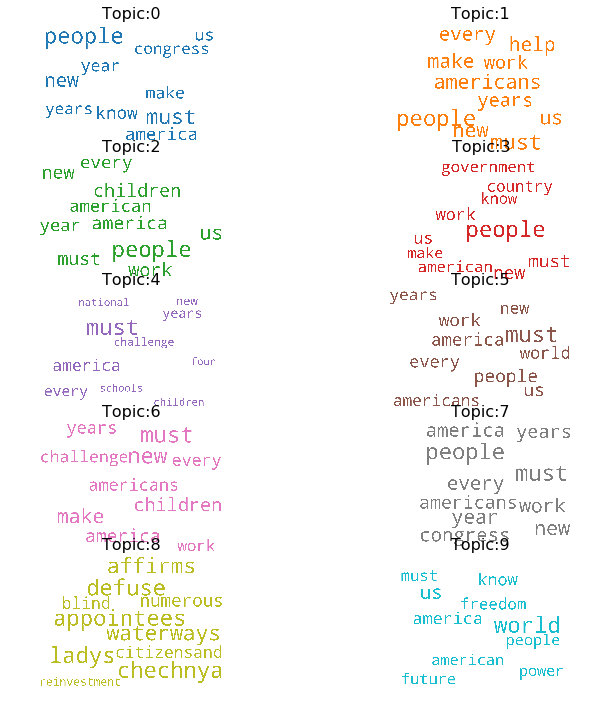

In [46]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = ldatwenti.show_topics(formatted=False)
fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic:' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.tight_layout()    
plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)

plt.show()

In [35]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldatwenti, corpustwenti, dictionary=dictionarytwenti)
vis

C:\Users\wingo\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.080578 -0.012300       1        1  40.959702
3     -0.056952 -0.058096       2        1  37.024006
6     -0.166970  0.012435       3        1  10.160158
9     -0.117263 -0.213049       4        1   7.536109
4     -0.262352  0.172110       5        1   4.222414
8      0.193892  0.081985       6        1   0.096478
5      0.112983  0.005502       7        1   0.000284
2      0.123169  0.004342       8        1   0.000284
1      0.129080  0.002698       9        1   0.000284
0      0.124992  0.004372      10        1   0.000284, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
674   Default  364.000000        must  364.000000  30.0000  30.0000
725   Default  349.000000      people  349.000000  29.0000  29.0000
54    Default  223.000000     america  223.000000  28.0000  28.0000
689   Default  290.000000         new  290.000000  27.0000  27.0000
1054  Default  230.000000          us  230.000000  26.0000  26.0000
365   Default  213.000000       every  213.000000  25.0000  25.0000
1106  Default  211.000000       years  211.000000  24.0000  24.0000
1092  Default  235.000000        work  235.000000  23.0000  23.0000
1104  Default  199.000000        year  199.000000  22.0000  22.0000
1098  Default  170.000000       world  170.000000  21.0000  21.0000
166   Default  177.000000    children  177.000000  20.0000  20.0000
575   Default  169.000000        know  169.000000  19.0000  19.0000
56    Default  187.000000   americans  187.000000  18.0000  18.0000
55    Default  193.000000    american  193.000000  17.0000  17.0000
213   Default  176.000000    congress  176.000000  16.0000  16.0000
631   Default  190.000000        make  190.000000  15.0000  15.0000
150   Default  145.000000        care  145.000000  14.0000  14.0000
457   Default  133.000000  government  133.000000  13.0000  13.0000
475   Default  135.000000      health  135.000000  12.0000  12.0000
482   Default  146.000000        help  146.000000  11.0000  11.0000
874   Default  111.000000         say  111.000000  10.0000  10.0000
696   Default  164.000000         one  164.000000   9.0000   9.0000
1007  Default  129.000000        time  129.000000   8.0000   8.0000
238   Default  125.000000     country  125.000000   7.0000   7.0000
401   Default  121.000000       first  121.000000   6.0000   6.0000
1011  Default  130.000000     tonight  130.000000   5.0000   5.0000
1067  Default   88.000000        want   88.000000   4.0000   4.0000
1882  Default   95.000000     welfare   95.000000   3.0000   3.0000
587   Default  127.000000        last  127.000000   2.0000   2.0000
976   Default  108.000000         tax  108.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
674   Topic10    0.000147        must  364.134369  -1.9500  -6.5245
689   Topic10    0.000117         new  290.262421  -1.9532  -6.7545
575   Topic10    0.000097        know  169.531830  -1.5964  -6.9353
54    Topic10    0.000097     america  223.128677  -1.8772  -6.9414
1104  Topic10    0.000087        year  199.019852  -1.8734  -7.0520
631   Topic10    0.000085        make  190.458267  -1.8518  -7.0744
1054  Topic10    0.000088          us  230.166077  -2.0055  -7.0387
213   Topic10    0.000079    congress  176.959045  -1.8433  -7.1394
1098  Topic10    0.000079       world  170.769760  -1.8178  -7.1495
1106  Topic10    0.000082       years  211.662750  -1.9954  -7.1124
475   Topic10    0.000075      health  135.077438  -1.6333  -7.1995
56    Topic10    0.000077   americans  187.470459  -1.9302  -7.1686
482   Topic10    0.000073        help  146.640579  -1.7408  -7.2248
587   Topic10    0.000069        last  127.859612  -1.6635  -7.2846
55    Topic10    0.000073    american  193.515869  -2.0113  -7.2179
150   Topic10    0.000067        care  145.98

## Twenty first Century lda model

In [36]:
dictionarytwentieth_first =corpora.Dictionary(twentieth_first['tokenized_words'])
corpustwentieth_first = [dictionarytwentieth_first.doc2bow(doc) for doc in twentieth_cent['tokenized_words']]
ldatwentieth_first = LdaModel(corpus=corpustwentieth_first, num_topics=10, id2word=dictionarytwentieth_first,
               alpha=1e-2, eta=0.5e-2,
               chunksize=2000, minimum_probability=0.0, passes=15)

In [37]:
twentieth_cent_topics = ldatwentieth_first.print_topics(num_words=10)
twentieth_cent_topics

[(0,
  '0.001*"people" + 0.001*"must" + 0.001*"work" + 0.001*"every" + 0.001*"year" + 0.001*"us" + 0.001*"america" + 0.001*"years" + 0.001*"american" + 0.001*"make"'),
 (1,
  '0.012*"people" + 0.009*"must" + 0.009*"new" + 0.008*"work" + 0.008*"us" + 0.007*"year" + 0.006*"american" + 0.006*"years" + 0.006*"make" + 0.006*"america"'),
 (2,
  '0.003*"people" + 0.002*"must" + 0.002*"make" + 0.002*"new" + 0.002*"work" + 0.001*"american" + 0.001*"years" + 0.001*"government" + 0.001*"us" + 0.001*"america"'),
 (3,
  '0.001*"must" + 0.001*"people" + 0.001*"us" + 0.001*"new" + 0.001*"american" + 0.001*"know" + 0.001*"work" + 0.001*"america" + 0.001*"congress" + 0.001*"years"'),
 (4,
  '0.018*"died" + 0.018*"existed" + 0.018*"determine" + 0.018*"expected" + 0.018*"owning" + 0.018*"nationalized" + 0.018*"acceptable" + 0.018*"alert" + 0.018*"burst" + 0.018*"midst"'),
 (5,
  '0.021*"plan" + 0.017*"deficit" + 0.017*"jobs" + 0.016*"investment" + 0.015*"country" + 0.014*"people" + 0.014*"government" + 0

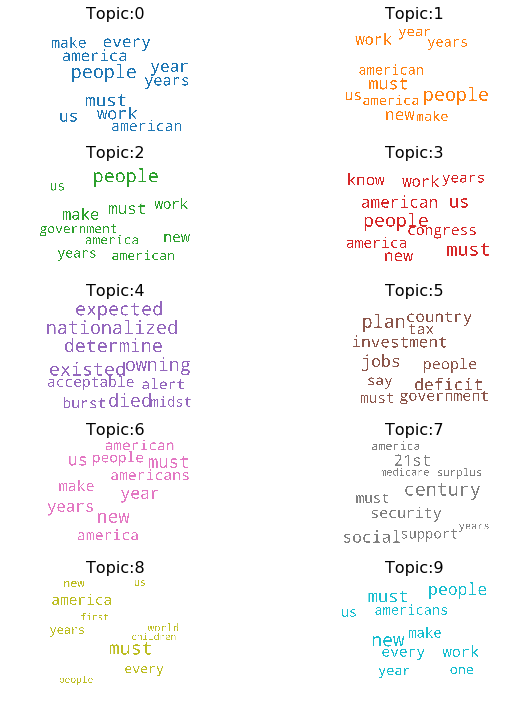

In [44]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = ldatwentieth_first.show_topics(formatted=False)
fig, axes = plt.subplots(5,2 , figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic:' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.margins(x=0, y=0)

plt.show()

In [39]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldatwentieth_first, corpustwentieth_first, dictionary=dictionarytwentieth_first)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.087974  0.013939       1        1  86.806801
8      0.211114 -0.088541       2        1   7.818504
5      0.228453  0.296447       3        1   3.020158
7      0.249005 -0.209241       4        1   2.305648
4     -0.136365  0.005802       5        1   0.047313
9     -0.122984 -0.006935       6        1   0.000316
6     -0.112217 -0.008050       7        1   0.000316
3     -0.148167 -0.005338       8        1   0.000316
2     -0.108128  0.009191       9        1   0.000316
0     -0.148685 -0.007273      10        1   0.000316, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
693   Default  349.000000      people  349.000000  30.0000  30.0000
623   Default  362.000000        must  362.000000  29.0000  29.0000
639   Default  289.000000         new  289.000000  28.0000  28.0000
1043  Default  230.000000          us  230.000000  27.0000  27.0000
1081  Default  235.000000        work  235.000000  26.0000  26.0000
581   Default  190.000000        make  190.000000  25.0000  25.0000
68    Default  222.000000     america  222.000000  24.0000  24.0000
69    Default  193.000000    american  193.000000  23.0000  23.0000
1092  Default  198.000000        year  198.000000  22.0000  22.0000
216   Default  176.000000    congress  176.000000  21.0000  21.0000
1093  Default  211.000000       years  211.000000  20.0000  20.0000
539   Default  169.000000        know  169.000000  19.0000  19.0000
70    Default  187.000000   americans  187.000000  18.0000  18.0000
358   Default  212.000000       every  212.000000  17.0000  17.0000
1085  Default  171.000000       world  171.000000  16.0000  16.0000
181   Default  177.000000    children  177.000000  15.0000  15.0000
153   Default  146.000000        care  146.000000  14.0000  14.0000
449   Default  134.000000  government  134.000000  13.0000  13.0000
656   Default  164.000000         one  164.000000  12.0000  12.0000
472   Default  134.000000      health  134.000000  11.0000  11.0000
473   Default  146.000000        help  146.000000  10.0000  10.0000
233   Default  124.000000     country  124.000000   9.0000   9.0000
1000  Default  129.000000        time  129.000000   8.0000   8.0000
437   Default   84.000000         get   84.000000   7.0000   7.0000
955   Default  103.000000     support  103.000000   6.0000   6.0000
967   Default  109.000000         tax  109.000000   5.0000   5.0000
1008  Default  130.000000     tonight  130.000000   4.0000   4.0000
524   Default  103.000000        jobs  103.000000   3.0000   3.0000
543   Default  127.000000        last  127.000000   2.0000   2.0000
851   Default   90.000000       right   90.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
4203  Topic10    0.000015    basement    0.021394   5.3798  -8.8288
4196  Topic10    0.000015    atlantic    0.021394   5.3798  -8.8288
2707  Topic10    0.000015   munitions    0.021394   5.3798  -8.8288
4197  Topic10    0.000015   authorize    0.021394   5.3798  -8.8288
4201  Topic10    0.000015   baltimore    0.021394   5.3798  -8.8288
1511  Topic10    0.000015      prayer    0.021394   5.3798  -8.8288
233   Topic10    0.000064     country  124.870193  -1.8255  -7.3622
581   Topic10    0.000068        make  190.450394  -2.1863  -7.3008
473   Topic10    0.000063        help  146.581863  -2.0005  -7.3769
1085  Topic10    0.000063       world  171.182190  -2.1478  -7.3690
539   Topic10    0.000063        know  169.611801  -2.1453  -7.3757
70    Topic10    0.000063   americans  187.358673  -2.2380  -7.3689
1008  Topic10    0.000059     tonight  130.529587  -1.9412  -7.4335
3622  Topic10    0.000015     manhood    0.021394   5.3798  -8.8288
3628  Topic10    0.000015     mislead    0.021394   5.3798  -8.8288
656   Topic10    0.000061         one  164.49